# Conditional GAN MNIST NUMBERS DATASET

## Import and Preprocess the Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <D9949A91-AC47-3F4B-804D-0B66B93A7A59> /opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


#### Check if GPU is available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the MNIST dataset and preprocess

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

### Define the Generator Model

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim, n_classes=10):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(n_classes, 10)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + 10, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.embedding(labels)
        noise_concat = torch.cat([noise, label_embedding], dim=1)
        img = self.model(noise_concat)
        return img.view(img.size(0), 1, 28, 28)

### Define the Discriminator Model

In [5]:
class Discriminator(nn.Module):
    def __init__(self, n_classes=10):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(n_classes, 10)
        self.model = nn.Sequential(
            nn.Linear(28 * 28 + 10, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img = img.view(img.size(0), 28 * 28)
        label_embedding = self.embedding(labels)
        img_concat = torch.cat([img, label_embedding], dim=1)
        return self.model(img_concat)

### Initialize models, optimizers, and loss function

In [6]:
latent_dim = 100
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

criterion = nn.BCELoss()

### Save the model after training

In [7]:
def save_model(generator, discriminator, epoch, path='models'):
    if not os.path.exists(path):
        os.makedirs(path)
    torch.save(generator.state_dict(), f'{path}/generator_epoch_{epoch}.pth')
    torch.save(discriminator.state_dict(), f'{path}/discriminator_epoch_{epoch}.pth')
    print(f'Models saved at epoch {epoch}.')




### Load the model for later use

In [8]:
def load_model(generator, discriminator, epoch, path='models'):
    generator.load_state_dict(torch.load(f'{path}/generator_epoch_{epoch}.pth'))
    discriminator.load_state_dict(torch.load(f'{path}/discriminator_epoch_{epoch}.pth'))
    print(f'Models loaded from epoch {epoch}.')

### Generating and saving images using the trained generator

In [9]:
def generate_and_save_images(generator, epoch, latent_dim, n_samples=10):
    generator.eval()
    noise = torch.randn(n_samples, latent_dim).to(device)
    labels = torch.randint(0, 10, (n_samples,)).to(device)
    with torch.no_grad():
        fake_images = generator(noise, labels).cpu()

    # Create a grid of generated images
    grid = make_grid(fake_images, nrow=5, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.savefig(f'generated_images_epoch_{epoch}.png')
    plt.show()

### Training loop

In [10]:
epochs = 150
n_critic = 5

for epoch in range(epochs):
    for i, (real_images, labels) in enumerate(train_loader):
        real_images, labels = real_images.to(device), labels.to(device)

        # Train the discriminator multiple times
        d_loss = 0
        for _ in range(n_critic):
            optimizer_d.zero_grad()
            real_validity = discriminator(real_images, labels)
            real_loss = criterion(real_validity, torch.ones(real_images.size(0), 1).to(device))

            noise = torch.randn(real_images.size(0), latent_dim).to(device)
            fake_labels = torch.randint(0, 10, (real_images.size(0),)).to(device)
            fake_images = generator(noise, fake_labels)
            fake_validity = discriminator(fake_images.detach(), fake_labels)
            fake_loss = criterion(fake_validity, torch.zeros(real_images.size(0), 1).to(device))

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_d.step()

        # Train the generator
        optimizer_g.zero_grad()
        noise = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_labels = torch.randint(0, 10, (real_images.size(0),)).to(device)
        fake_images = generator(noise, fake_labels)
        fake_validity = discriminator(fake_images, fake_labels)
        g_loss = criterion(fake_validity, torch.ones(real_images.size(0), 1).to(device))

        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch + 1}/{epochs}] | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}')

    # Save the model and generated images every 10th epoch
    if (epoch + 1) % 30 == 0:
        save_model(generator, discriminator, epoch + 1)
        generate_and_save_images(generator, epoch + 1, latent_dim)


Epoch [1/10] | D Loss: 0.2561 | G Loss: 2.6337
Epoch [2/10] | D Loss: 0.0397 | G Loss: 5.6395
Epoch [3/10] | D Loss: 0.0807 | G Loss: 4.5479
Epoch [4/10] | D Loss: 0.0758 | G Loss: 6.3817
Epoch [5/10] | D Loss: 0.2116 | G Loss: 9.0956
Epoch [6/10] | D Loss: 0.1494 | G Loss: 8.0590
Epoch [7/10] | D Loss: 0.0904 | G Loss: 6.9286
Epoch [8/10] | D Loss: 0.1221 | G Loss: 6.9107
Epoch [9/10] | D Loss: 0.1738 | G Loss: 7.3477
Epoch [10/10] | D Loss: 0.1291 | G Loss: 5.5372


### Generate images after training

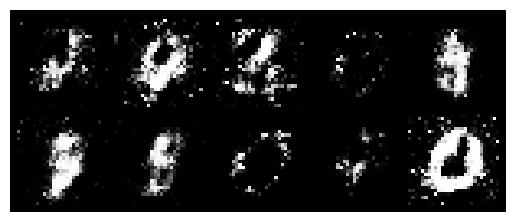

In [11]:

generate_and_save_images(generator, epochs, latent_dim)

# Function to generate an image given a specific label and noise
def generate_image(generator, latent_dim, label):
    generator.eval()
    noise = torch.randn(1, latent_dim).to(device)
    label_tensor = torch.tensor([label]).to(device)
    with torch.no_grad():
        generated_image = generator(noise, label_tensor).cpu()

    plt.imshow(generated_image.view(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

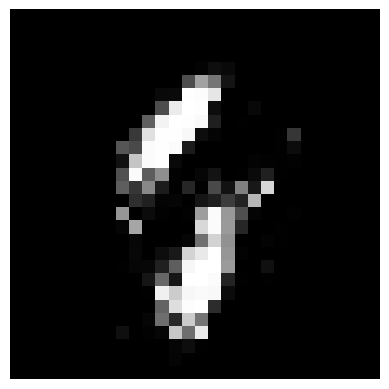

In [12]:
# Example: Generate an image of label 5
generate_image(generator, latent_dim, label=5)